# Exercise 1.4

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

**NB! The exercise is formulated in a Jupyter notebook for ease of communication, but you should feel *very* free to carry out the entire exercise without the notebook. If you do carry it out in a notebook, please finish by migrating your code over to a script that you can run from the terminal**

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

We always check that we are running on a GPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [3]:
batch_size = 64
# load the CIFAR10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|█████████████████████████████████| 170498071/170498071 [00:06<00:00, 25012383.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


* Make a CNN to train on the CIFAR10 dataset

In [4]:
class Network(nn.Module):
    def __init__(self, BN=False):
        super(Network, self).__init__()
        if BN:
            self.convolutional = nn.Sequential(
                    nn.Conv2d(3, 8, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(8),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(8, 16, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(16))
        else:
            self.convolutional = nn.Sequential(
                    nn.Conv2d(3, 8, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),
                    nn.Conv2d(8, 16, kernel_size=3, padding=1),
                    nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*16, 500),
                nn.ReLU(),
                nn.Linear(500, 10))#,
                #nn.Softmax(dim=1))
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fully_connected(x)
        return x

In [5]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        #return F.nll_loss(torch.log(output), target)
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [6]:
print("SGD lr: 0.1")
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict1 = train(model, optimizer)


SGD lr: 0.1


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.666	 test: 1.388	 Accuracy train: 39.8%	 test: 49.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.265	 test: 1.227	 Accuracy train: 55.0%	 test: 56.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.084	 test: 1.164	 Accuracy train: 61.5%	 test: 59.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.956	 test: 1.212	 Accuracy train: 66.2%	 test: 58.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.836	 test: 1.048	 Accuracy train: 70.6%	 test: 63.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.725	 test: 1.084	 Accuracy train: 74.3%	 test: 63.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.609	 test: 1.037	 Accuracy train: 78.5%	 test: 65.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.507	 test: 1.313	 Accuracy train: 82.3%	 test: 61.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.408	 test: 1.170	 Accuracy train: 85.7%	 test: 65.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.323	 test: 1.491	 Accuracy train: 88.8%	 test: 62.9%


In [7]:
print("SGD lr: 0.01")
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
out_dict2 = train(model, optimizer)

SGD lr: 0.01


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.121	 test: 1.873	 Accuracy train: 23.1%	 test: 34.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.776	 test: 1.656	 Accuracy train: 36.9%	 test: 40.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.595	 test: 1.522	 Accuracy train: 43.1%	 test: 45.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.472	 test: 1.397	 Accuracy train: 47.4%	 test: 49.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.374	 test: 1.346	 Accuracy train: 50.9%	 test: 51.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.303	 test: 1.275	 Accuracy train: 53.6%	 test: 54.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.244	 test: 1.200	 Accuracy train: 55.7%	 test: 57.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.196	 test: 1.235	 Accuracy train: 57.5%	 test: 56.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.153	 test: 1.159	 Accuracy train: 59.1%	 test: 59.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.115	 test: 1.144	 Accuracy train: 60.6%	 test: 59.3%


In [8]:
print("Adam lr: 0.1")
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
out_dict3 = train(model, optimizer)


Adam lr: 0.1


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 4.736	 test: 2.321	 Accuracy train: 9.9%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.314	 Accuracy train: 9.8%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.311	 test: 2.311	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.308	 Accuracy train: 9.9%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.310	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.311	 test: 2.321	 Accuracy train: 10.2%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.317	 Accuracy train: 10.1%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.311	 test: 2.311	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.330	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.313	 Accuracy train: 9.9%	 test: 10.0%


In [9]:
print("Adam lr: 0.01")

model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
out_dict4 = train(model, optimizer)


Adam lr: 0.01


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.820	 test: 1.633	 Accuracy train: 33.4%	 test: 40.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.643	 test: 1.545	 Accuracy train: 40.3%	 test: 43.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.576	 test: 1.575	 Accuracy train: 42.6%	 test: 44.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.520	 test: 1.489	 Accuracy train: 44.9%	 test: 46.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.495	 test: 1.538	 Accuracy train: 46.2%	 test: 44.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.459	 test: 1.469	 Accuracy train: 47.1%	 test: 47.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.435	 test: 1.503	 Accuracy train: 48.3%	 test: 46.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.424	 test: 1.478	 Accuracy train: 49.0%	 test: 47.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.386	 test: 1.455	 Accuracy train: 50.5%	 test: 47.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.357	 test: 1.468	 Accuracy train: 51.4%	 test: 48.5%


In [10]:

print("Adam lr: 0.01 with BatchNorm")

model = Network(BN=True)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
out_dict5 = train(model, optimizer)

Adam lr: 0.01 with BatchNorm


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.597	 test: 1.219	 Accuracy train: 45.8%	 test: 56.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.196	 test: 1.201	 Accuracy train: 57.8%	 test: 58.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.089	 test: 1.159	 Accuracy train: 62.1%	 test: 59.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.013	 test: 1.063	 Accuracy train: 65.0%	 test: 63.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.937	 test: 1.081	 Accuracy train: 67.7%	 test: 63.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.876	 test: 1.164	 Accuracy train: 70.0%	 test: 62.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.814	 test: 1.129	 Accuracy train: 72.5%	 test: 63.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.744	 test: 1.147	 Accuracy train: 74.8%	 test: 64.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.704	 test: 1.332	 Accuracy train: 76.5%	 test: 61.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.666	 test: 1.256	 Accuracy train: 77.8%	 test: 62.5%


Text(0.5, 1.0, 'Accuracy')

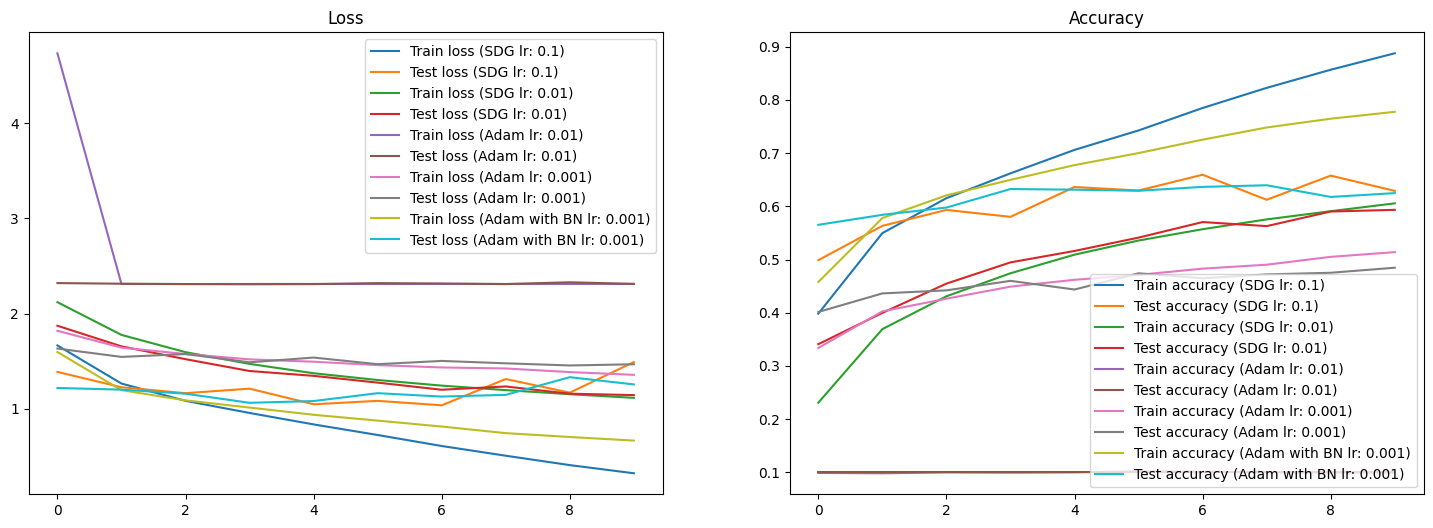

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(out_dict1['train_loss'], label='Train loss (SDG lr: 0.1)')
axes[0].plot(out_dict1['test_loss'], label='Test loss (SDG lr: 0.1)')

axes[1].plot(out_dict1['train_acc'], label='Train accuracy (SDG lr: 0.1)')
axes[1].plot(out_dict1['test_acc'], label='Test accuracy (SDG lr: 0.1)')



axes[0].plot(out_dict2['train_loss'], label='Train loss (SDG lr: 0.01)')
axes[0].plot(out_dict2['test_loss'], label='Test loss (SDG lr: 0.01)')

axes[1].plot(out_dict2['train_acc'], label='Train accuracy (SDG lr: 0.01)')
axes[1].plot(out_dict2['test_acc'], label='Test accuracy (SDG lr: 0.01)')



axes[0].plot(out_dict3['train_loss'], label='Train loss (Adam lr: 0.01)')
axes[0].plot(out_dict3['test_loss'], label='Test loss (Adam lr: 0.01)')

axes[1].plot(out_dict3['train_acc'], label='Train accuracy (Adam lr: 0.01)')
axes[1].plot(out_dict3['test_acc'], label='Test accuracy (Adam lr: 0.01)')



axes[0].plot(out_dict4['train_loss'], label='Train loss (Adam lr: 0.001)')
axes[0].plot(out_dict4['test_loss'], label='Test loss (Adam lr: 0.001)')

axes[1].plot(out_dict4['train_acc'], label='Train accuracy (Adam lr: 0.001)')
axes[1].plot(out_dict4['test_acc'], label='Test accuracy (Adam lr: 0.001)')



axes[0].plot(out_dict5['train_loss'], label='Train loss (Adam with BN lr: 0.001)')
axes[0].plot(out_dict5['test_loss'], label='Test loss (Adam with BN lr: 0.001)')

axes[1].plot(out_dict5['train_acc'], label='Train accuracy (Adam with BN lr: 0.001)')
axes[1].plot(out_dict5['test_acc'], label='Test accuracy (Adam with BN lr: 0.001)')



axes[0].legend()
axes[1].legend()
axes[0].set_title('Loss')
axes[1].set_title('Accuracy')

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [12]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features, BN=False):
        super(ResNetBlock, self).__init__()
        if BN:
            self.convolutional = nn.Sequential(nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1),
                                            nn.ReLU(),
                                            nn.BatchNorm2d(n_features),
                                            nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1))
            self.relu = nn.Sequential(nn.ReLU(),nn.BatchNorm2d(n_features))
        else:
            self.convolutional = nn.Sequential(nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1))
            self.relu = nn.ReLU()

    def forward(self, x):
        
        r = self.convolutional(x)
        out = self.relu(x + r)

        return out

The following code is a sanity of your residual block network

In [13]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)

x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [14]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3, BN=False):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        if BN:
            conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(n_features)]
        else:
            conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                        nn.ReLU()]
        
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features, BN))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10))#,
                                #nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [15]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict1 = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.695	 test: 1.622	 Accuracy train: 39.1%	 test: 39.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.286	 test: 1.413	 Accuracy train: 54.0%	 test: 50.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.039	 test: 1.886	 Accuracy train: 62.9%	 test: 43.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.794	 test: 1.284	 Accuracy train: 72.0%	 test: 57.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.494	 test: 3.215	 Accuracy train: 82.8%	 test: 41.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.256	 test: 2.016	 Accuracy train: 91.3%	 test: 54.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.138	 test: 2.053	 Accuracy train: 95.3%	 test: 57.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.090	 test: 2.224	 Accuracy train: 97.0%	 test: 58.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.064	 test: 2.418	 Accuracy train: 97.9%	 test: 57.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.044	 test: 3.259	 Accuracy train: 98.6%	 test: 53.8%


In [16]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
out_dict2 = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.477	 test: 1.280	 Accuracy train: 46.3%	 test: 54.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.070	 test: 1.094	 Accuracy train: 61.7%	 test: 61.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.788	 test: 1.152	 Accuracy train: 72.1%	 test: 60.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.472	 test: 1.263	 Accuracy train: 83.6%	 test: 60.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.215	 test: 1.684	 Accuracy train: 92.7%	 test: 59.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.107	 test: 2.111	 Accuracy train: 96.5%	 test: 60.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.083	 test: 2.275	 Accuracy train: 97.1%	 test: 59.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.073	 test: 2.335	 Accuracy train: 97.6%	 test: 59.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.051	 test: 2.757	 Accuracy train: 98.3%	 test: 60.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.047	 test: 2.736	 Accuracy train: 98.4%	 test: 59.9%


In [17]:
model = ResNet(3, 8, BN = True)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
out_dict3 = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.264	 test: 1.080	 Accuracy train: 55.1%	 test: 62.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.728	 test: 1.016	 Accuracy train: 74.5%	 test: 65.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.262	 test: 1.372	 Accuracy train: 91.0%	 test: 63.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.113	 test: 1.710	 Accuracy train: 96.3%	 test: 64.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.088	 test: 1.784	 Accuracy train: 97.1%	 test: 63.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.077	 test: 2.008	 Accuracy train: 97.5%	 test: 64.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.070	 test: 2.036	 Accuracy train: 97.9%	 test: 63.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.058	 test: 2.188	 Accuracy train: 98.2%	 test: 63.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.053	 test: 2.254	 Accuracy train: 98.4%	 test: 63.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.055	 test: 2.420	 Accuracy train: 98.3%	 test: 63.4%


Text(0.5, 1.0, 'Accuracy')

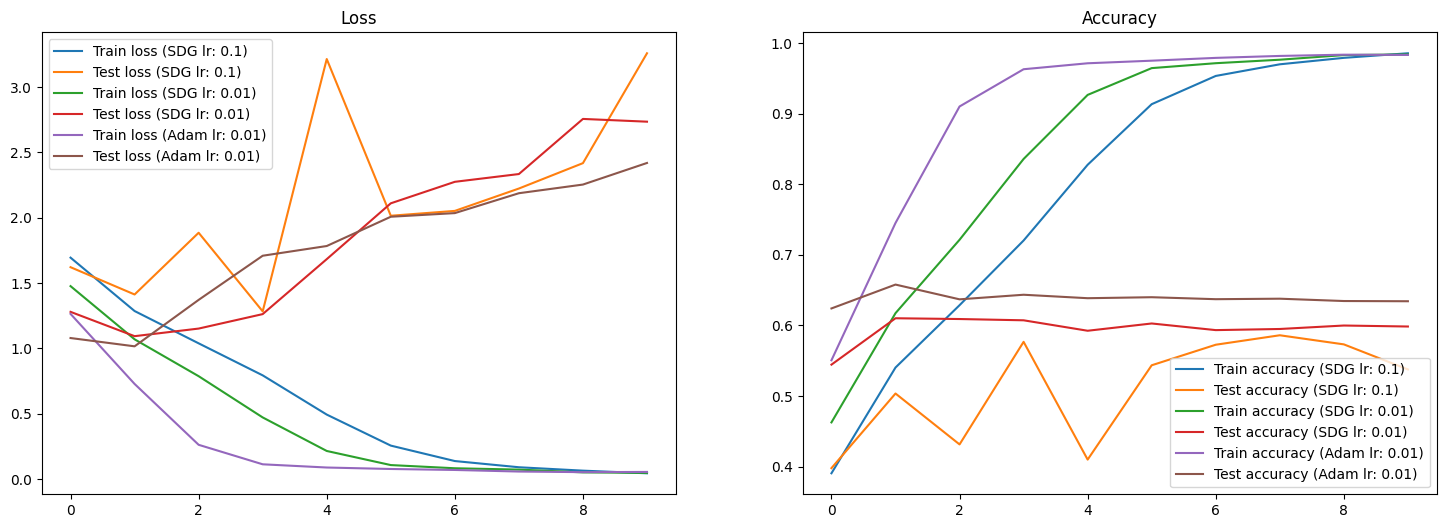

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(out_dict1['train_loss'], label='Train loss (SDG lr: 0.1)')
axes[0].plot(out_dict1['test_loss'], label='Test loss (SDG lr: 0.1)')

axes[1].plot(out_dict1['train_acc'], label='Train accuracy (SDG lr: 0.1)')
axes[1].plot(out_dict1['test_acc'], label='Test accuracy (SDG lr: 0.1)')



axes[0].plot(out_dict2['train_loss'], label='Train loss (SDG lr: 0.001)')
axes[0].plot(out_dict2['test_loss'], label='Test loss (SDG lr: 0.001)')

axes[1].plot(out_dict2['train_acc'], label='Train accuracy (SDG lr: 0.001)')
axes[1].plot(out_dict2['test_acc'], label='Test accuracy (SDG lr: 0.001)')



axes[0].plot(out_dict3['train_loss'], label='Train loss (Adam lr: 0.001)')
axes[0].plot(out_dict3['test_loss'], label='Test loss (Adam lr: 0.001)')

axes[1].plot(out_dict3['train_acc'], label='Train accuracy (Adam lr: 0.001)')
axes[1].plot(out_dict3['test_acc'], label='Test accuracy (Adam lr: 0.001)')



axes[0].legend()
axes[1].legend()
axes[0].set_title('Loss')
axes[1].set_title('Accuracy')



Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.